In [187]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# plt.style.use('dark_background')
import warnings
warnings.filterwarnings('ignore') 

start = time.perf_counter()

In [188]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 674 entries, 0 to 673
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               674 non-null    object 
 1   Player             674 non-null    object 
 2   MatchId            674 non-null    object 
 3   Map                674 non-null    object 
 4   Category           674 non-null    object 
 5   Playlist           674 non-null    object 
 6   Input              674 non-null    object 
 7   Queue              674 non-null    object 
 8   PreCsr             674 non-null    int64  
 9   PostCsr            674 non-null    int64  
 10  Rank               674 non-null    int64  
 11  WasAtStart         674 non-null    int64  
 12  WasAtEnd           674 non-null    int64  
 13  WasInProgressJoin  674 non-null    int64  
 14  Mmr                2 non-null      float64
 15  Outcome            674 non-null    object 
 16  Accuracy           674 non

In [189]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
## Per 10 Mins and Excess
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
df['ExcessKD'] = df['KD'] - round((df['ExpectedKills'] / df['ExpectedDeaths']),2)
## Lifetime
df['LifetimeKD'] = df['Kills'].cumsum() / df['Deaths'].cumsum()
df['LifetimeDmgRatio'] = df['DamageDone'].cumsum() / df['DamageTaken'].cumsum()
df['LifetimeAcc'] = df['ShotsLanded'].cumsum() / df['ShotsFired'].cumsum() * 100
df['LifetimeBodyPct'] = df['KillsBody'].cumsum() / df['Kills'].cumsum() *100
df['LifetimeMeleePct'] = df['KillsMelee'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeHSPct'] = df['KillsHeadshot'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeGrenadePct'] = df['KillsGrenade'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimePowerPct'] = df['KillsPower'].cumsum() / df['Kills'].cumsum() * 100

df['Map'] = df['Map'].str.replace(' - Ranked', '')

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'WasAtStart', 'WasAtEnd',
            'WasInProgressJoin', 'AssistsEmp', 'AssistsDriver', 'AssistsCallout', 'VehicleDestroys',
            'VehicleHijacks', 'Perfects', 'PreCsr'],axis=1)
dfr = df[df['Date']> '2023-01-01']
dfr = dfr[dfr['Playlist'] == 'Ranked Arena']
dfr['Csr'] = dfr['PostCsr'].replace(0, method='ffill')
dfr = dfr[dfr['Outcome'] != 'Draw']
dfr = dfr[dfr['Outcome'] != 'Left']
dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0})
dfr['LifetimeWinRate'] = (dfr['Outcome'].cumsum() / 
                          (dfr['Outcome'].cumsum() + 
                           dfr['Outcome'].eq(0).cumsum())).fillna(0)
dfr = dfr.drop(['Playlist', 'PostCsr'], axis=1).reset_index()
# dfr.loc[:4, 'Csr'] = 808
dfr.to_csv('df.csv')
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               444 non-null    int64         
 1   Date                444 non-null    datetime64[ns]
 2   Map                 444 non-null    object        
 3   Category            444 non-null    object        
 4   Rank                444 non-null    int64         
 5   Outcome             444 non-null    int64         
 6   Accuracy            444 non-null    float64       
 7   DamageDone          444 non-null    int64         
 8   DamageTaken         444 non-null    int64         
 9   ShotsFired          444 non-null    int64         
 10  ShotsLanded         444 non-null    int64         
 11  ShotsMissed         444 non-null    int64         
 12  KD                  444 non-null    float64       
 13  KDA                 444 non-null    float64       

In [190]:
dfr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,444.0,405.704955,152.827396,140.000000,276.750000,406.500000,537.250000,673.000000
Rank,444.0,3.945946,2.170343,1.000000,2.000000,4.000000,5.000000,8.000000
Outcome,444.0,0.538288,0.499094,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,444.0,51.488964,5.448805,24.390000,48.407500,51.560000,54.682500,80.560000
DamageDone,444.0,5143.128378,1812.217686,347.000000,3828.750000,4865.500000,6307.250000,12673.000000
DamageTaken,444.0,4418.218468,1516.276077,276.000000,3424.500000,4197.500000,5338.000000,9962.000000
ShotsFired,444.0,233.664414,78.631997,16.000000,180.000000,223.500000,289.500000,468.000000
ShotsLanded,444.0,120.067568,41.664032,4.000000,93.000000,113.000000,148.000000,281.000000
ShotsMissed,444.0,113.596847,40.369871,7.000000,86.000000,109.000000,140.000000,261.000000
KD,444.0,1.243491,0.655044,0.000000,0.860000,1.125000,1.442500,6.000000


In [191]:
print("Kills           ", dfr.Kills.sum())
print("Expected Kills  ", round(dfr.ExpectedKills.sum(),))
print("Deaths          ", dfr.Deaths.sum())
print("Expected Deaths ", round(dfr.ExpectedDeaths.sum(),))
print("KD              ", round(dfr.Kills.sum() / dfr.Deaths.sum(),2))
print("Excepcted KD    ", round(dfr.ExpectedKills.sum() / dfr.ExpectedDeaths.sum(),2))


Kills            6446
Expected Kills   6362
Deaths           5709
Expected Deaths  6296
KD               1.13
Excepcted KD     1.01


In [192]:
dfr.tail()

,index,Date,Map,Category,Rank,Outcome,Accuracy,DamageDone,DamageTaken,ShotsFired,...,LifetimeKD,LifetimeDmgRatio,LifetimeAcc,LifetimeBodyPct,LifetimeMeleePct,LifetimeHSPct,LifetimeGrenadePct,LifetimePowerPct,Csr,LifetimeWinRate
439,669,2024-01-30 05:06:00,Streets,Slayer,4,1,41.94,3051,3813,155,...,1.112808,1.157360,49.720756,28.892889,10.328533,50.236274,6.964446,3.577858,1075,0.538636
440,670,2024-01-30 05:15:36,Solitude,King of the Hill,5,0,43.73,4982,6409,279,...,1.111527,1.156457,49.711884,28.898876,10.337079,50.213483,6.977528,3.573034,1065,0.537415
441,671,2024-01-30 05:35:58,Solitude,Slayer,3,1,45.13,3749,3491,195,...,1.111790,1.156350,49.707147,28.919313,10.324318,50.218831,6.968915,3.568623,1072,0.538462
442,672,2024-01-30 05:46:00,Aquarius,CTF 5 Captures,4,1,48.68,5987,4887,265,...,1.111333,1.156474,49.705705,28.910802,10.331690,50.212909,6.981174,3.563424,1079,0.539503
443,673,2024-01-30 06:02:05,Forbidden,CTF 3 Captures,5,0,44.54,6667,7330,348,...,1.110035,1.155806,49.696208,28.910271,10.326695,50.234952,6.970239,3.557843,1070,0.538288


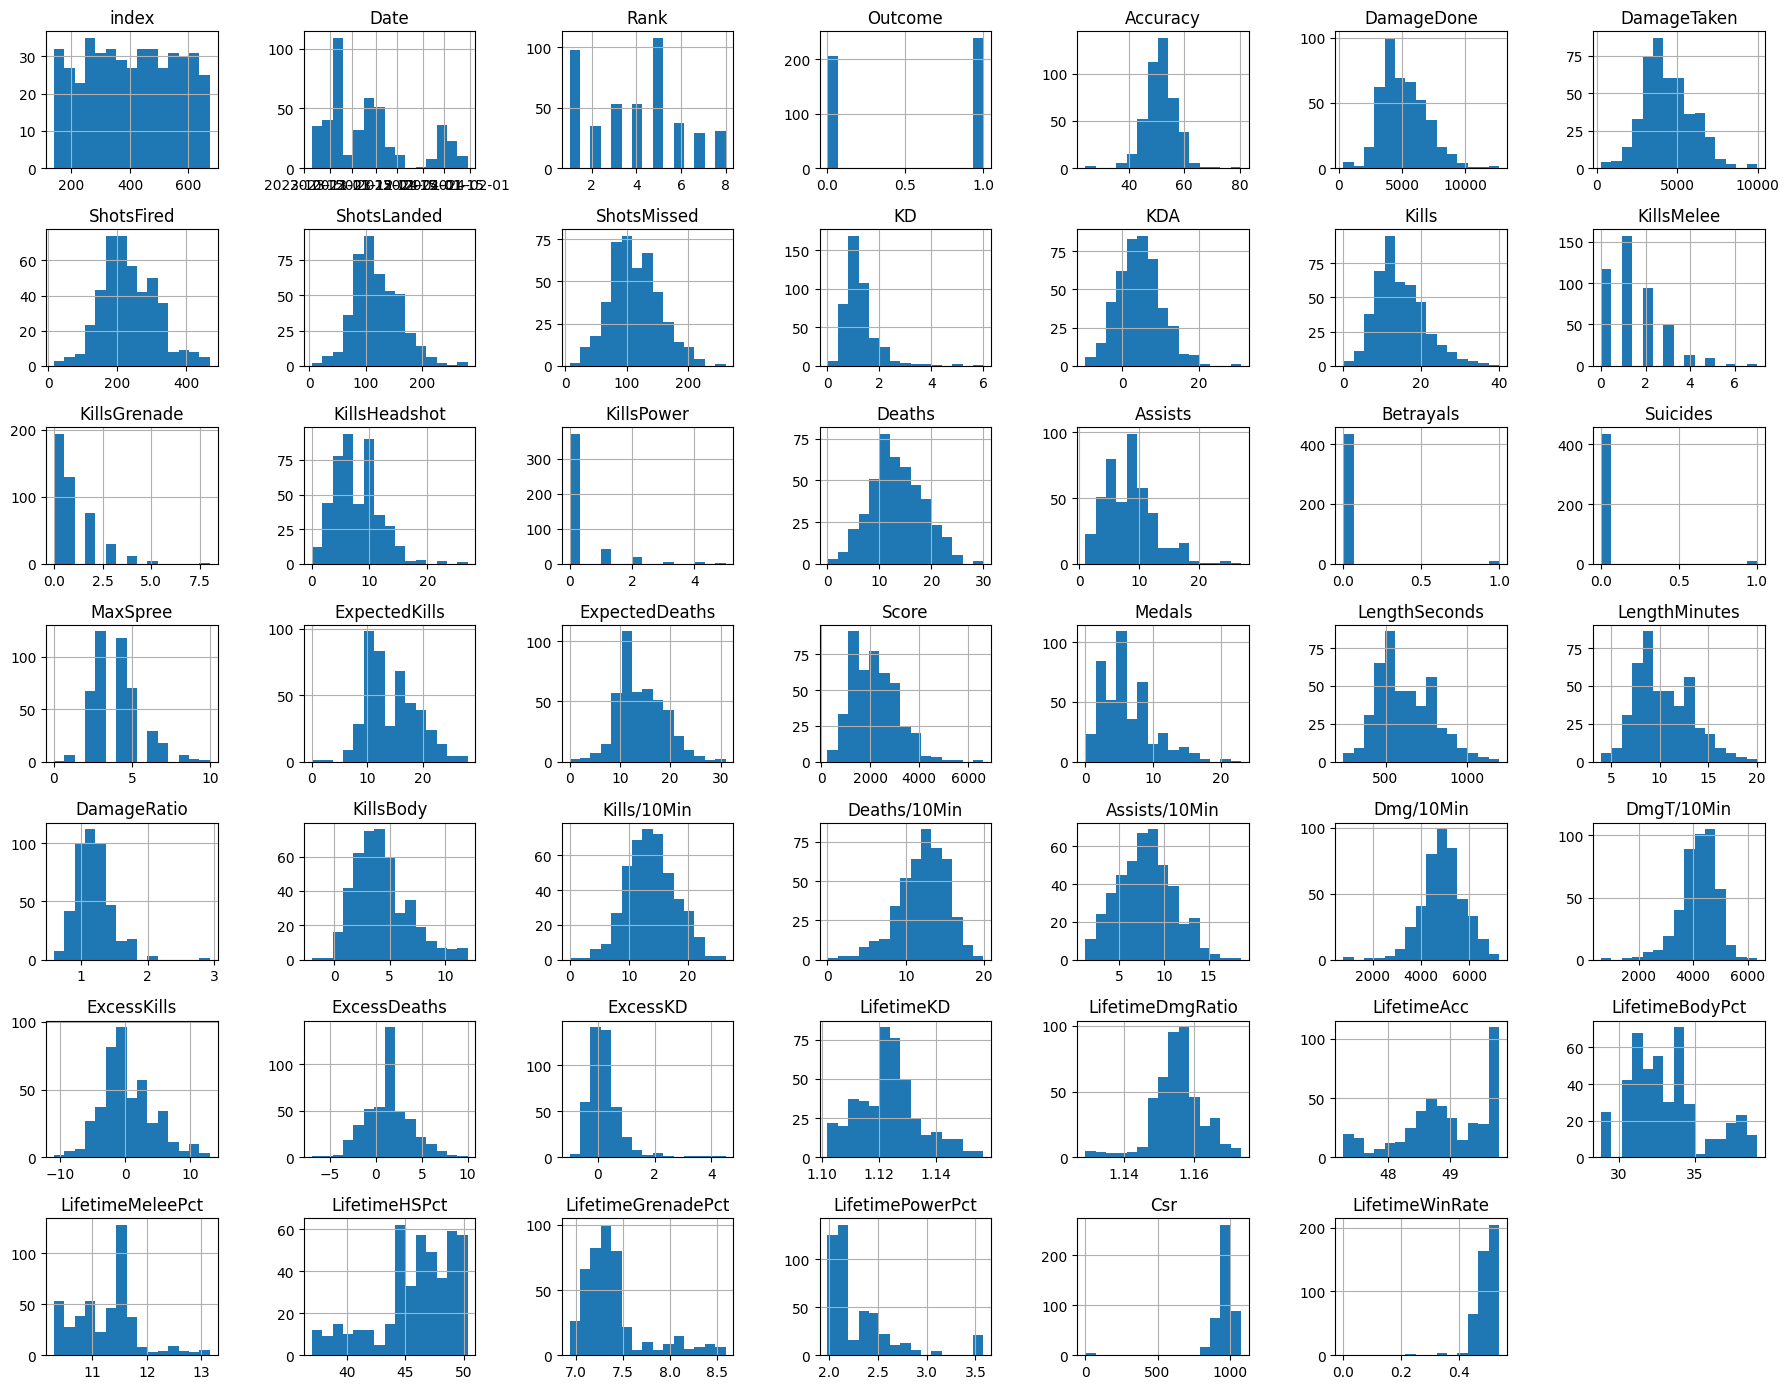

In [193]:
dfr.hist(bins=15, figsize=(18, 14))
plt.tight_layout()
plt.show()

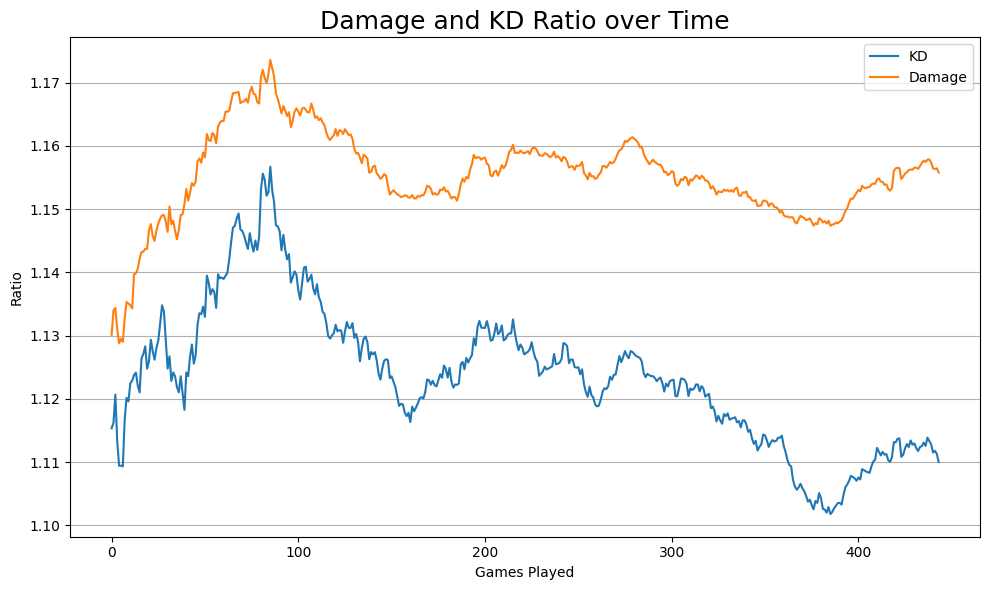

In [194]:
plt.figure(figsize=(10,6))
plt.plot(dfr['LifetimeKD'], label='KD' )
plt.plot(dfr['LifetimeDmgRatio'], label='Damage')
plt.title('Damage and KD Ratio over Time', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('Plots/DamKDRatios.png', dpi=300)
plt.show()

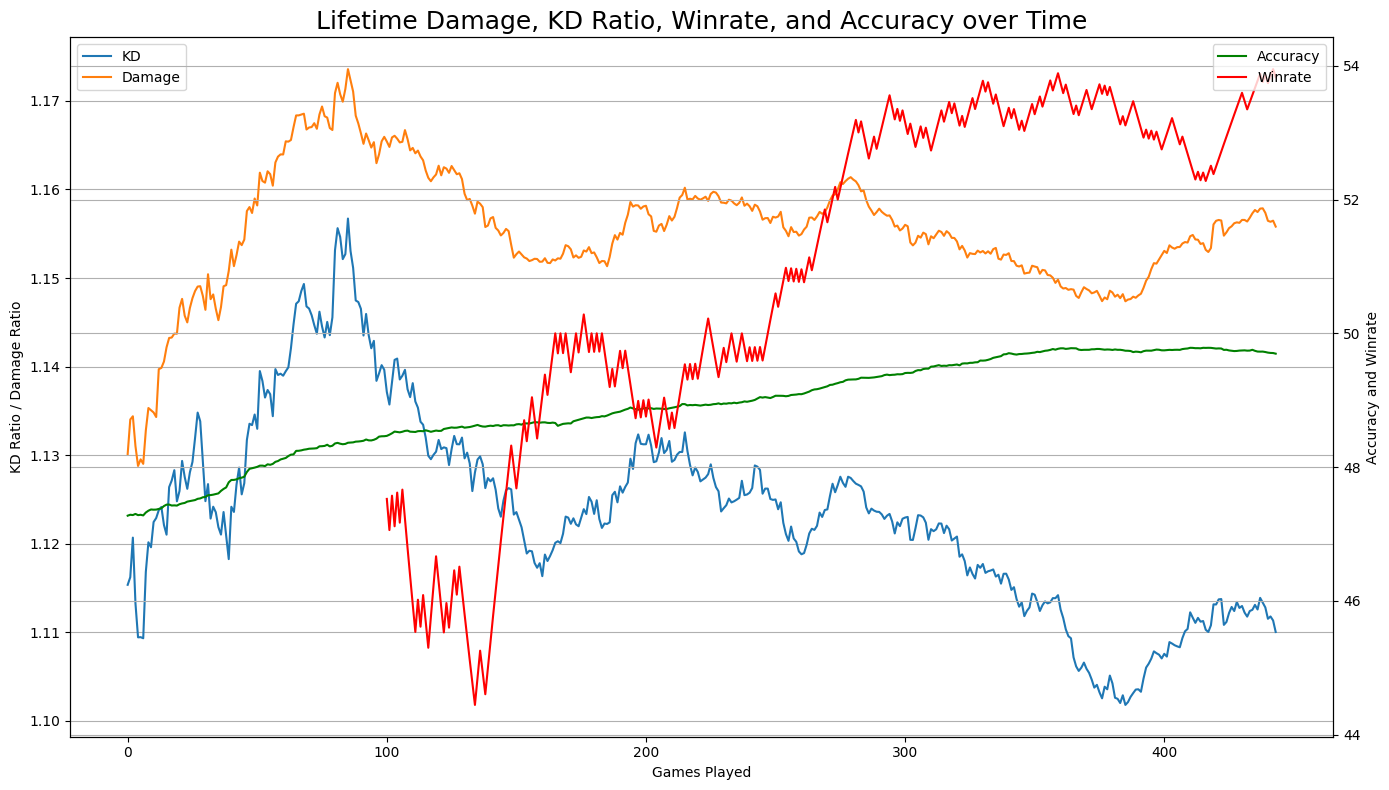

In [195]:
# Smooth the LifetimeWinRate using a 10-game moving average
# dfr['SmoothedAccuracy'] = dfr['Accuracy'].rolling(window=25).mean()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['LifetimeAcc'], color='green', label='Accuracy')
ax2.plot(dfr['LifetimeWinRate'][100:]*100, color='red', label='Winrate')
ax1.set_title('Lifetime Damage, KD Ratio, Winrate, and Accuracy over Time', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('Accuracy and Winrate')
# max_y_value = df['LifetimeAcc'].max()
ax1.yaxis.grid(True)
ax2.yaxis.grid(True)
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
# plt.savefig('Plots/DamKDRatiosAcc.png', dpi=300)
plt.show()

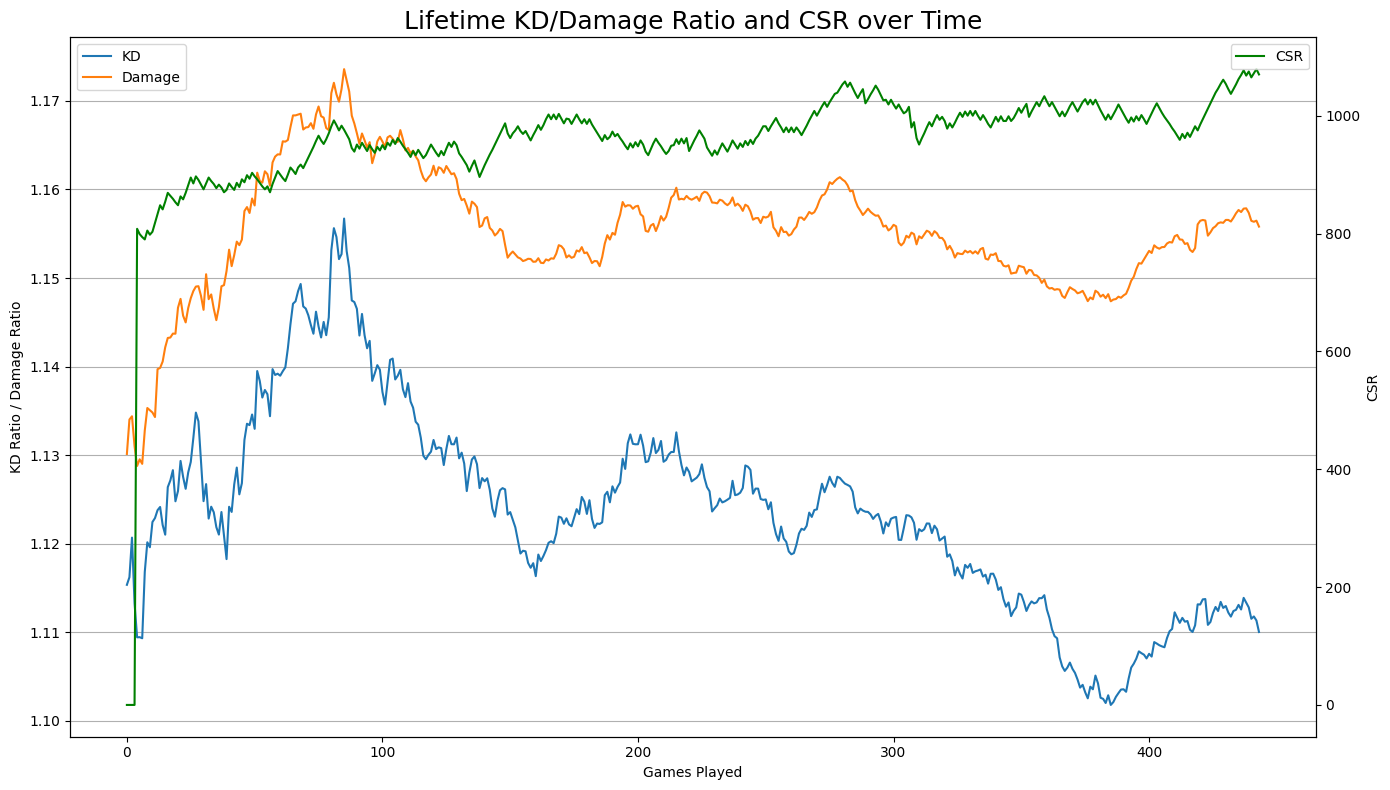

In [196]:
# Smooth the LifetimeWinRate using a 10-game moving average
# dfr['SmoothedAccuracy'] = dfr['Accuracy'].rolling(window=25).mean()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['Csr'], color='green', label='CSR')
ax1.set_title('Lifetime KD/Damage Ratio and CSR over Time', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('CSR')
# max_y_value = df['LifetimeAcc'].max()
ax1.yaxis.grid(True)
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
# plt.savefig('Plots/DamKDRatiosAcc.png', dpi=300)
plt.show()

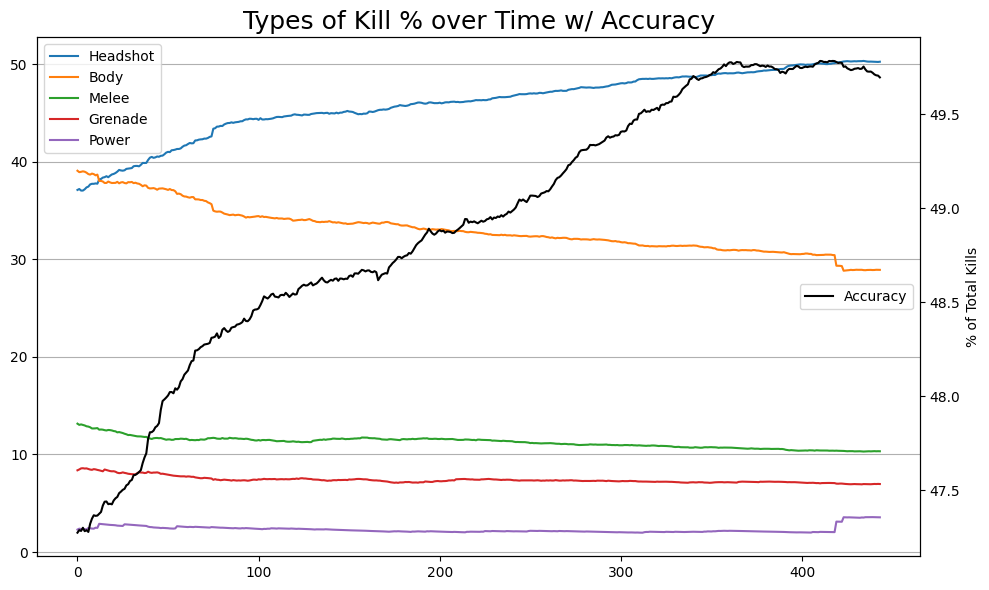

In [197]:
plt.figure(figsize=(10,6))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeHSPct'], label='Headshot')
ax1.plot(dfr['LifetimeBodyPct'], label='Body')
ax1.plot(dfr['LifetimeMeleePct'], label='Melee')
ax1.plot(dfr['LifetimeGrenadePct'], label='Grenade')
ax1.plot(dfr['LifetimePowerPct'], label='Power')
ax2.plot(dfr['LifetimeAcc'], label='Accuracy', color='black')
plt.title('Types of Kill % over Time w/ Accuracy', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('% of Total Kills')
ax1.legend(loc='best')
ax2.legend(loc='right')
ax1.grid(True, axis='y')
plt.tight_layout()
# plt.savefig('Plots/DamKDRatios.png', dpi=300)
plt.show()

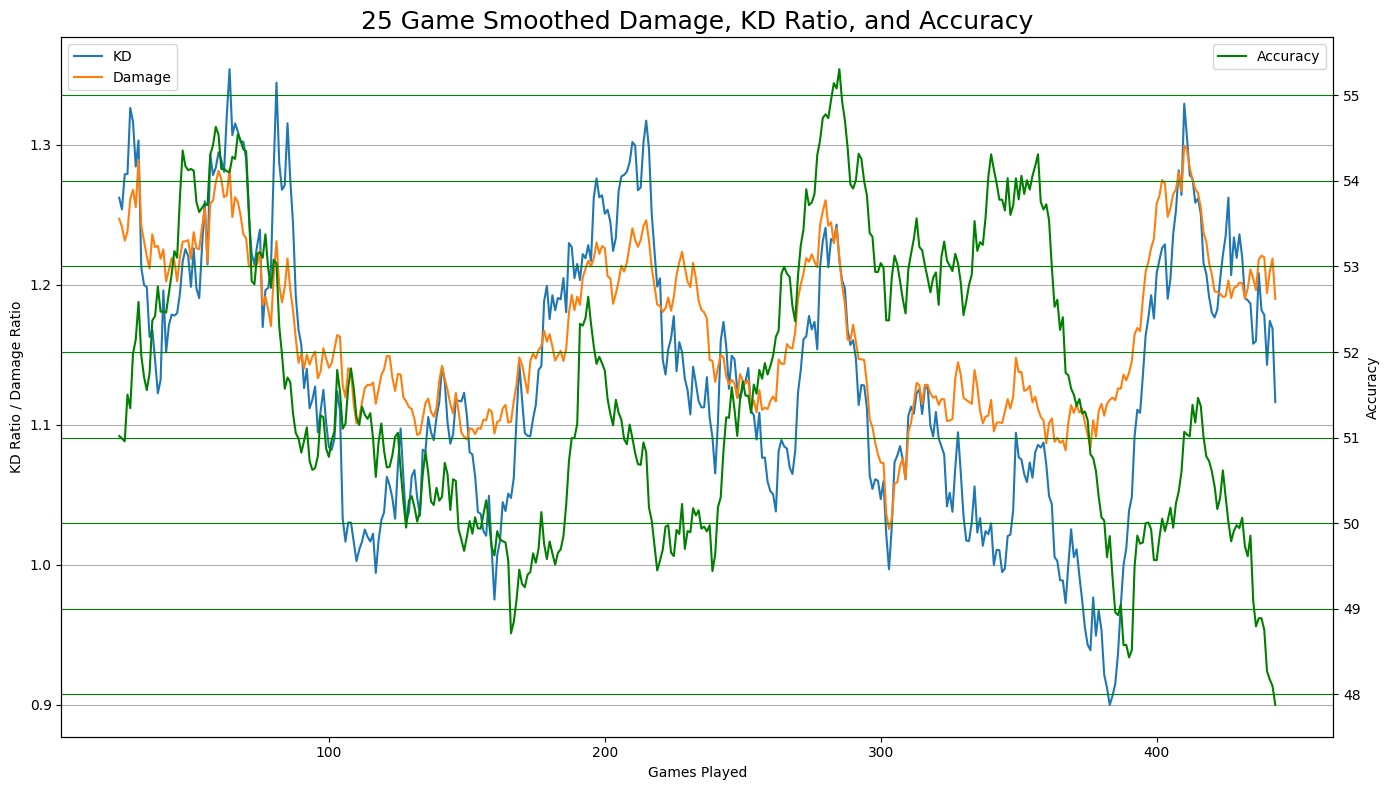

In [198]:
# Smooth the LifetimeWinRate using a 10-game moving average
# Set roll to ** game moving average
roll = 25
dfr['SmoothedAccuracy'] = dfr['ShotsLanded'].rolling(window=roll).sum() / dfr['ShotsFired'].rolling(window=roll).sum() * 100
dfr['SmoothedDmgRatio'] = dfr['DamageDone'].rolling(window=roll).sum() / dfr['DamageTaken'].rolling(window=roll).sum()
dfr['SmoothedKD'] = dfr['Kills'].rolling(window=roll).sum() / dfr['Deaths'].rolling(window=roll).sum()


plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['SmoothedKD'], label='KD' )
ax1.plot(dfr['SmoothedDmgRatio'], label='Damage')
ax2.plot(dfr['SmoothedAccuracy'], color='green', label='Accuracy')
ax1.set_title(f'{roll} Game Smoothed Damage, KD Ratio, and Accuracy', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('Accuracy')
max_y_value = df['Accuracy'].max()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True, axis='y')
ax2.grid(True, axis='y', color='green')
plt.tight_layout()
plt.savefig('Plots/DamKDRatiosAccSmooth.png', dpi=300)
plt.show()

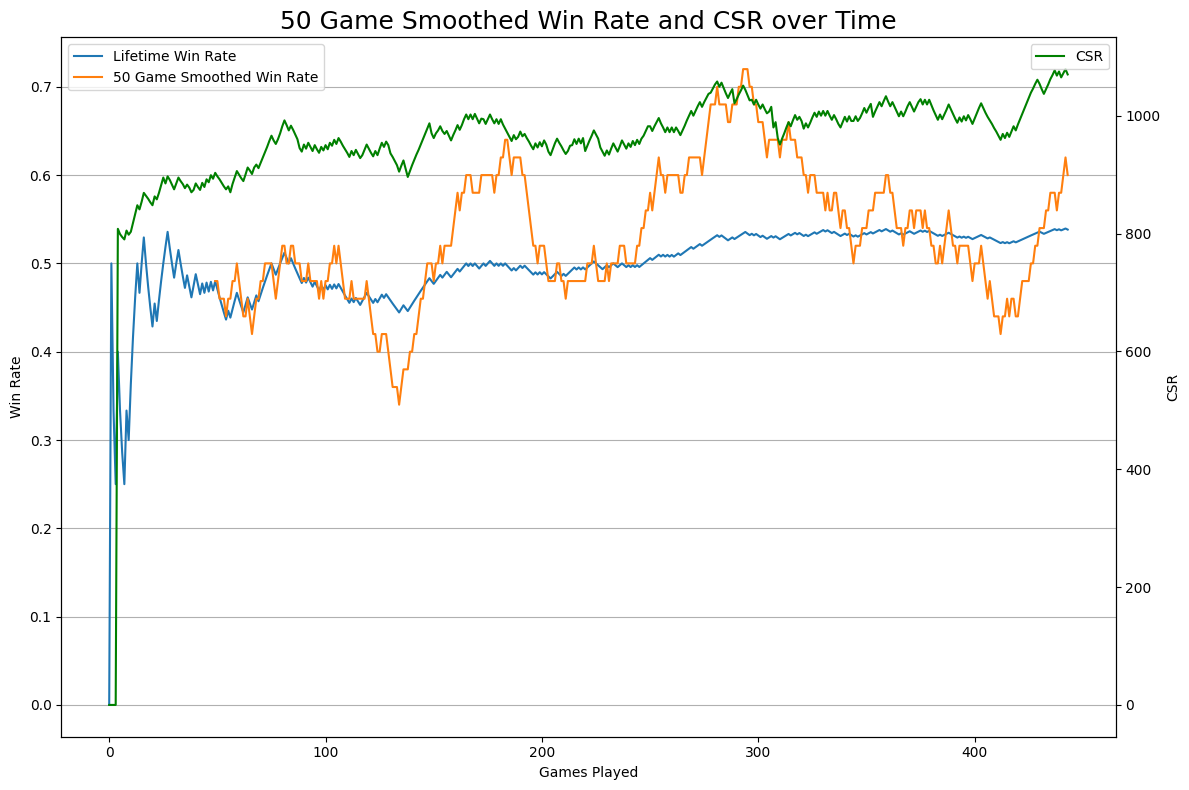

In [199]:
# Smooth the LifetimeWinRate using a 10-game moving average
# dfr['SmoothedWinRate'] = dfr['LifetimeWinRate'].rolling(window=15).mean()
roll = 50
dfr['SmoothedWinRate'] = dfr['Outcome'].rolling(window=roll).sum() / dfr['Outcome'].rolling(window=roll).count()

plt.figure(figsize=(12,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeWinRate'], label='Lifetime Win Rate' )
ax1.plot(dfr['SmoothedWinRate'], label=(f'{roll} Game Smoothed Win Rate'))
ax2.plot(dfr['Csr'], color='green', label='CSR')
ax1.set_title(f'{roll} Game Smoothed Win Rate and CSR over Time', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('Win Rate')
ax2.set_ylabel('CSR')
ax1.yaxis.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/WinRateCSR.png', dpi=300)
plt.show()

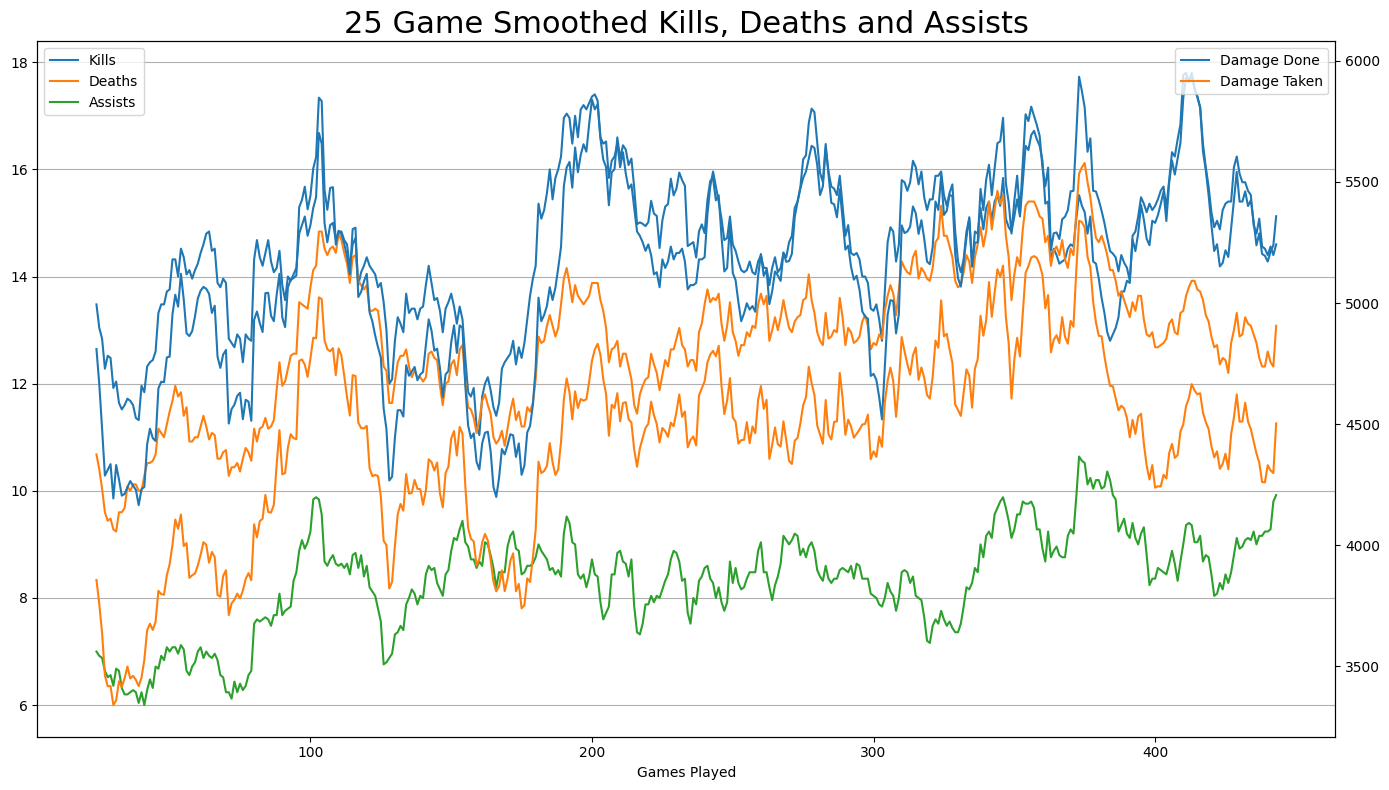

In [200]:
# Smooth the LifetimeWinRate using a 10-game moving average
# Set roll to ** game moving average
roll = 25
dfr['SmoothedKills'] = dfr['Kills'].rolling(window=roll).mean() 
dfr['SmoothedDeaths'] = dfr['Deaths'].rolling(window=roll).mean() 
dfr['SmoothedAssists'] = dfr['Assists'].rolling(window=roll).mean()
dfr['SmoothedDmg'] = dfr['DamageDone'].rolling(window=roll).mean()
dfr['SmoothedDmgT'] = dfr['DamageTaken'].rolling(window=roll).mean()


plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = plt.twinx(ax1)
ax1.plot(dfr['SmoothedKills'], label='Kills' )
ax1.plot(dfr['SmoothedDeaths'], label='Deaths')
ax1.plot(dfr['SmoothedAssists'], label='Assists')
ax2.plot(dfr['SmoothedDmg'], label='Damage Done')
ax2.plot(dfr['SmoothedDmgT'], label='Damage Taken')
ax1.set_title(f'{roll} Game Smoothed Kills, Deaths and Assists', fontsize=22)
ax1.set_xlabel('Games Played')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_facecolor('red')


ax1.yaxis.grid(True)
plt.tight_layout()
plt.savefig('Plots/KDASmooth.png', dpi=300)
plt.show()

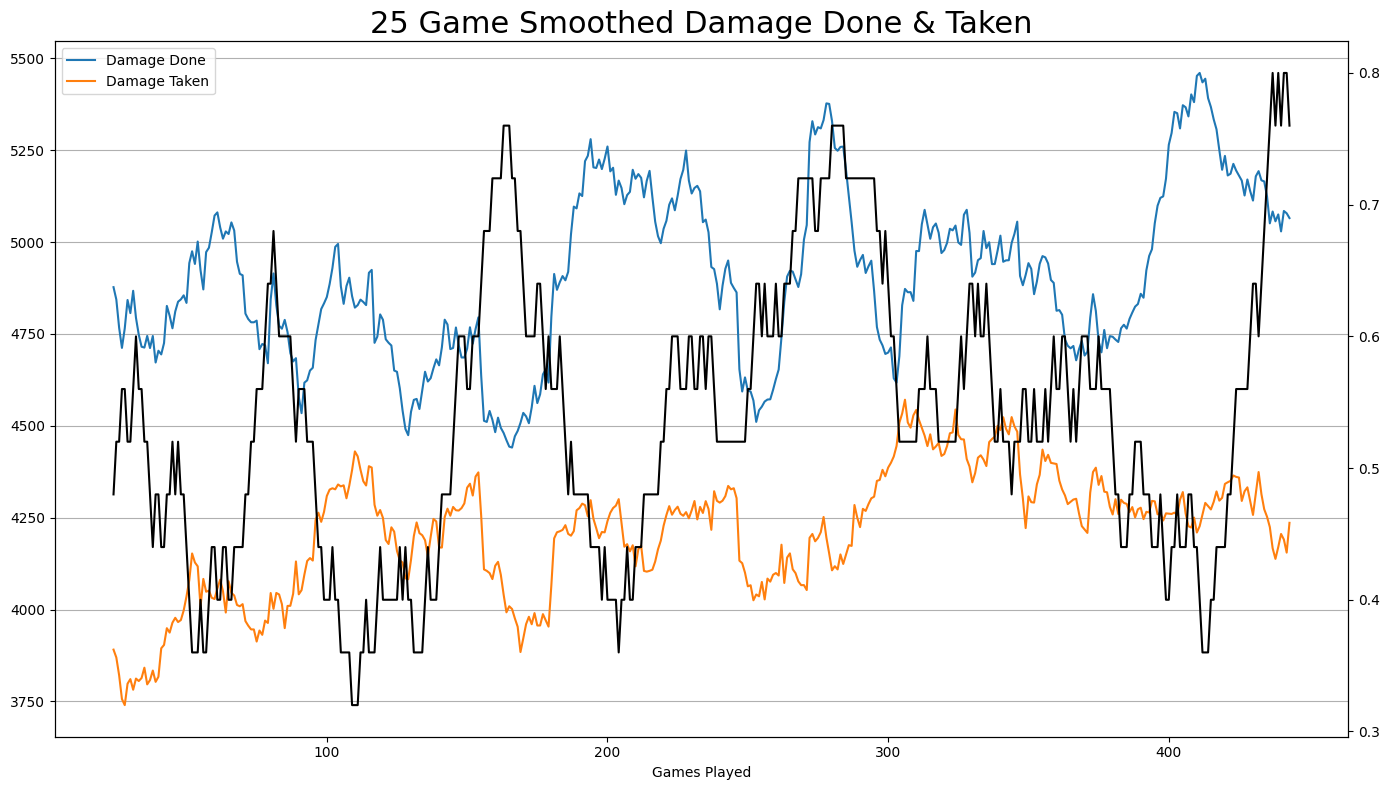

,index,Date,Map,Category,Rank,Outcome,Accuracy,DamageDone,DamageTaken,ShotsFired,...,LifetimeWinRate,SmoothedAccuracy,SmoothedDmgRatio,SmoothedKD,SmoothedWinRate,SmoothedKills,SmoothedDeaths,SmoothedAssists,SmoothedDmg,SmoothedDmgT
0,140,2023-10-19 19:49:41,Solitude,King of the Hill,5,0,52.31,7146,4957,325,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,141,2023-10-19 20:06:10,Solitude,Strongholds,1,1,50.49,7974,5281,309,...,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,142,2023-10-19 20:25:03,Recharge,King of the Hill,5,0,46.36,6889,5906,343,...,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,143,2023-10-19 20:42:40,Streets,Extraction,5,0,53.61,3854,4960,194,...,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,144,2023-10-19 20:55:21,Argyle,CTF 3 Captures,3,1,41.56,2769,3501,231,...,0.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [201]:
# Smooth the LifetimeWinRate using a 10-game moving average
# Set roll to ** game moving average
roll = 25
dfr['SmoothedDmg'] = dfr['Dmg/10Min'].rolling(window=roll).mean()
dfr['SmoothedDmgT'] = dfr['DmgT/10Min'].rolling(window=roll).mean()
dfr['SmoothedWinRate'] = dfr['Outcome'].rolling(window=roll).sum() / dfr['Outcome'].rolling(window=roll).count()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['SmoothedDmg'], label='Damage Done')
ax1.plot(dfr['SmoothedDmgT'], label='Damage Taken')
ax2.plot(dfr['SmoothedWinRate'], label='Winrate', color='black')
ax1.set_title(f'{roll} Game Smoothed Damage Done & Taken', fontsize=22)
ax1.set_xlabel('Games Played')
ax1.legend(loc='upper left')
ax1.yaxis.grid(True)
plt.tight_layout()
plt.savefig('Plots/KDASmooth.png', dpi=300)
plt.show()

dfr.head()

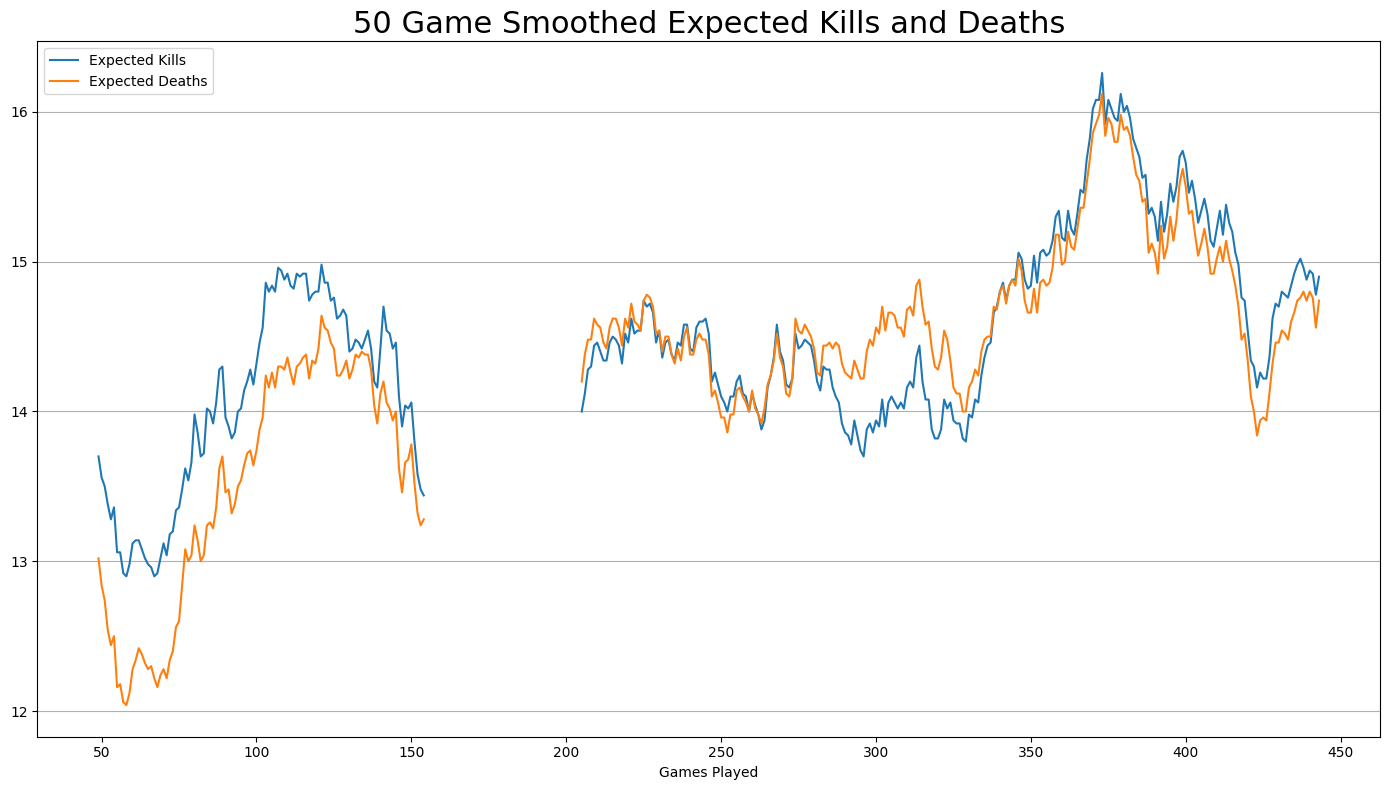

In [202]:
# Smooth the LifetimeWinRate using a 10-game moving average
# Set roll to ** game moving average
roll = 50
dfr['SmoothedExKills'] = dfr['ExpectedKills'].rolling(window=roll).mean()
dfr['SmoothedExDeaths'] = dfr['ExpectedDeaths'].rolling(window=roll).mean()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax1.plot(dfr['SmoothedExKills'], label='Expected Kills')
ax1.plot(dfr['SmoothedExDeaths'], label='Expected Deaths')
ax1.set_title(f'{roll} Game Smoothed Expected Kills and Deaths', fontsize=22)
ax1.set_xlabel('Games Played')
ax1.legend(loc='upper left')
ax1.yaxis.grid(True)
plt.tight_layout()
plt.savefig('Plots/ExKDSmooth.png', dpi=300)
plt.show()

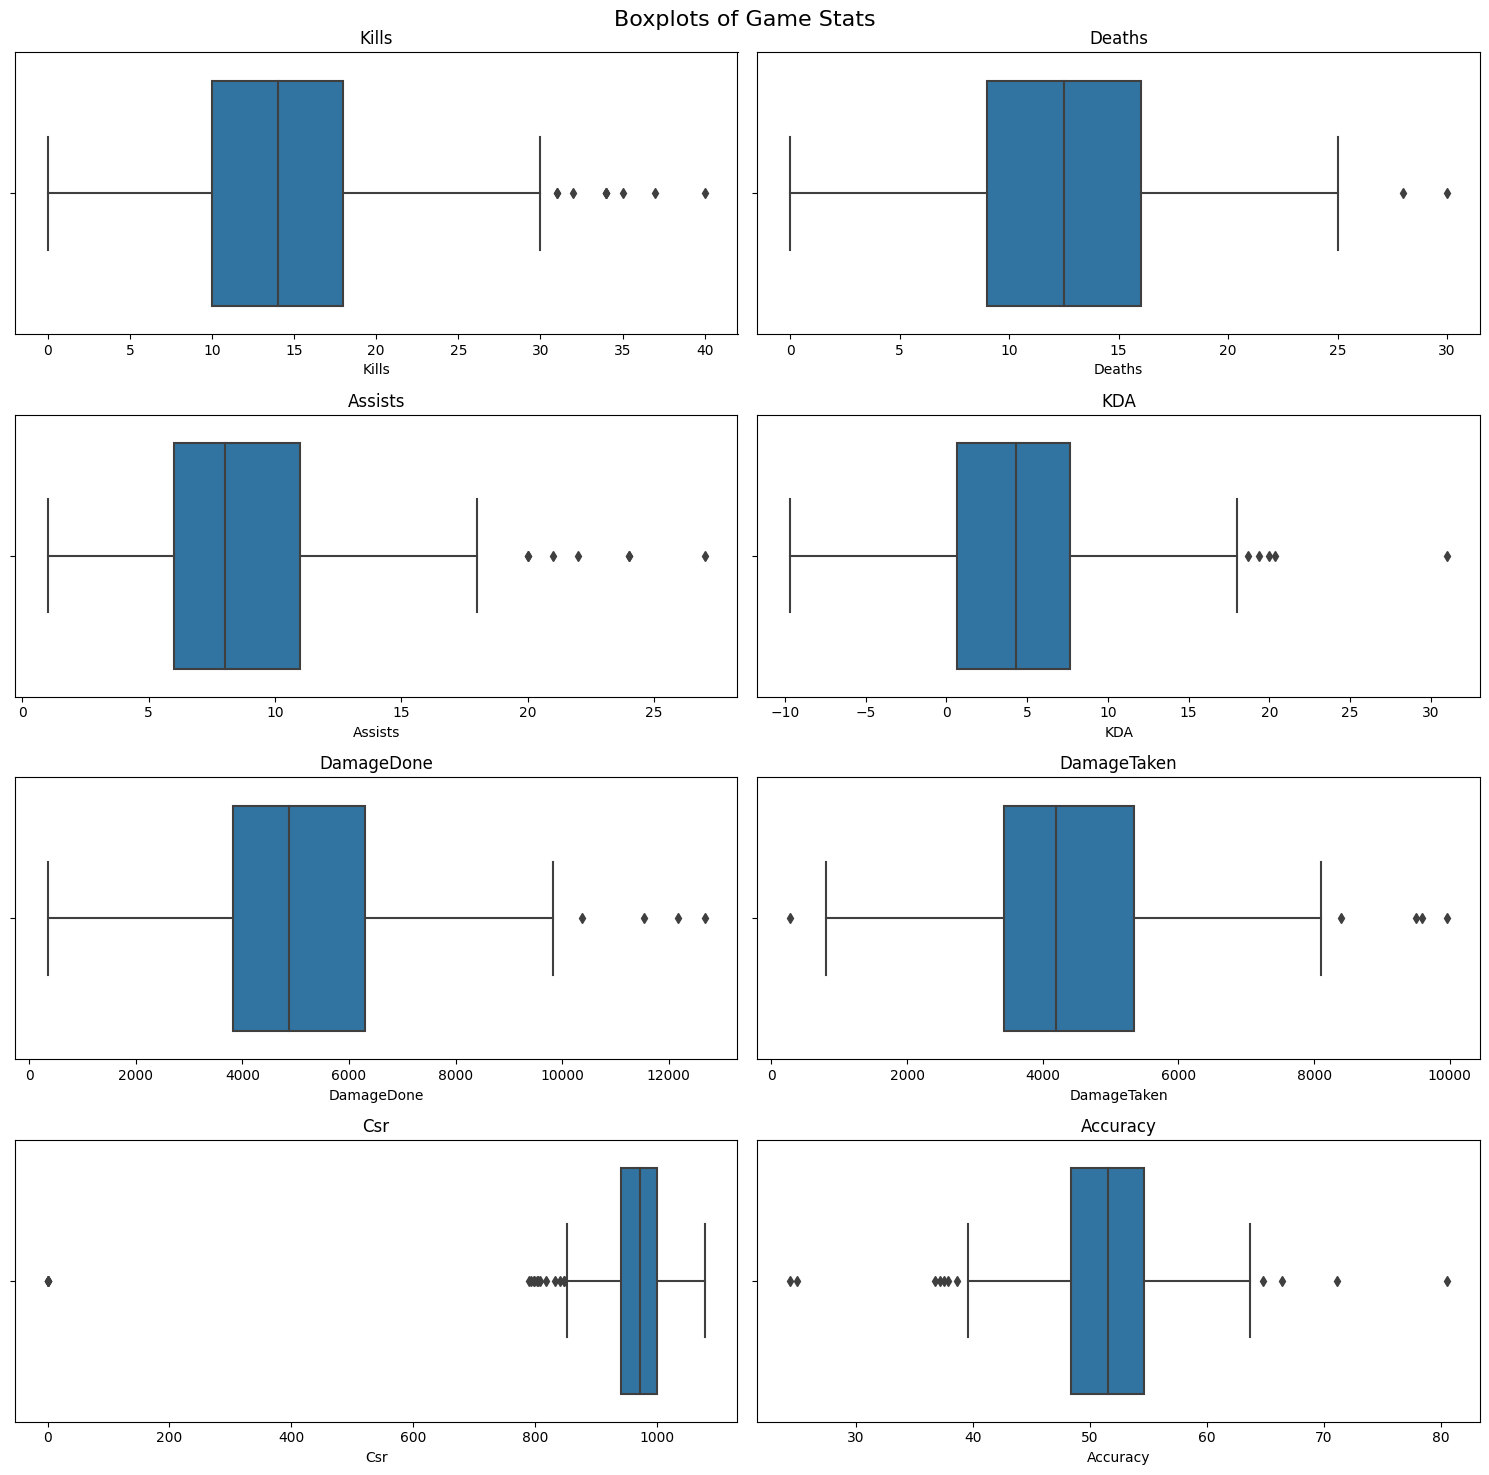

In [203]:
import seaborn as sns
import matplotlib.pyplot as plt
columns = ['Kills', 'Deaths', 'Assists', 'KDA', 'DamageDone', 'DamageTaken',
            'Csr', 'Accuracy']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each column in a separate boxplot
for i, column in enumerate(columns):
    sns.boxplot(x=dfr[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.suptitle('Boxplots of Game Stats', fontsize=16)
plt.tight_layout()
plt.savefig('Plots/Boxplots.png', dpi=300)
plt.show()


In [204]:
mod = 5

# dfmod = dfr.loc[dfr['Deaths'] < mod, 
#                 ['Kills', 'Deaths', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome']
#                 ].sort_values('DamageDone', ascending=False)

# Column Choice <>
# dfmod = dfr.loc[dfr['Deaths'] < mod]

# Last * Games
dfmod = dfr.tail(mod)

# print(dfmod.head())
print(f'Overall KD: {round(dfmod["Kills"].sum() / dfmod["Deaths"].sum(),2)}')
print(f"Accuracy: {round(dfmod['ShotsLanded'].sum() / dfmod['ShotsFired'].sum()*100,2)}")
print(f"Damage Ratio: {round(dfmod['DamageDone'].sum() / dfmod['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfmod['Outcome']==1).sum()}-{(dfmod['Outcome']==0).sum()}")
print(f"Max CSR: {dfmod['Csr'].max()}")

Overall KD: 0.76
Accuracy: 45.01
Damage Ratio: 0.94
Win-Loss: 3-2
Max CSR: 1079


In [205]:
dfw = dfr.loc[dfr['Outcome'] == 1, 
                ['Kills', 'Deaths', 'Assists', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills', ascending=False)

dfl = dfr.loc[dfr['Outcome'] == 0, 
                ['Kills', 'Deaths', 'Assists', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills', ascending=False)

print('Overall')
print(f'Overall KD: {round(dfr["Kills"].sum() / dfr["Deaths"].sum(),2)}')
print(f"Average Kills: {round(dfr['Kills'].mean(),2)}")
print(f"Average Deaths: {round(dfr['Deaths'].mean(),2)}")
print(f"Average Assists: {round(dfr['Assists'].mean(),2)}")
print(f"Average Accuracy: {round(dfr['ShotsLanded'].sum() / dfr['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfr['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfr['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfr['DamageDone'].sum() / dfr['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfr['Outcome']==1).sum()}-{(dfr['Outcome']==0).sum()}")
print('----------------------------')
print('Wins')
print(f'Overall KD: {round(dfw["Kills"].sum() / dfw["Deaths"].sum(),2)}')
print(f"Average Kills: {round(dfw['Kills'].mean(),2)}")
print(f"Average Deaths: {round(dfw['Deaths'].mean(),2)}")
print(f"Average Assists: {round(dfw['Assists'].mean(),2)}")
print(f"Average Accuracy: {round(dfw['ShotsLanded'].sum() / dfw['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfw['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfw['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfw['DamageDone'].sum() / dfw['DamageTaken'].sum(),2)}")
print(f"Wins: {(dfw['Outcome']==1).sum()}")
print('----------------------------')
print('Losses')
print(f'Overall KD: {round(dfl["Kills"].sum() / dfl["Deaths"].sum(),2)}')
print(f"Average Kills: {round(dfl['Kills'].mean(),2)}")
print(f"Average Deaths: {round(dfl['Deaths'].mean(),2)}")
print(f"Average Assists: {round(dfl['Assists'].mean(),2)}")
print(f"Average Accuracy: {round(dfl['ShotsLanded'].sum() / dfl['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfl['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfl['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfl['DamageDone'].sum() / dfl['DamageTaken'].sum(),2)}")
print(f"Losses: {(dfl['Outcome']==0).sum()}")

Overall
Overall KD: 1.13
Average Kills: 14.52
Average Deaths: 12.86
Average Assists: 8.36
Average Accuracy: 51.38
Average Damage Done: 5143
Average Damage Taken: 4418
Damage Ratio: 1.16
Win-Loss: 239-205
----------------------------
Wins
Overall KD: 1.27
Average Kills: 14.3
Average Deaths: 11.29
Average Assists: 8.52
Average Accuracy: 51.52
Average Damage Done: 4971
Average Damage Taken: 4065
Damage Ratio: 1.22
Wins: 239
----------------------------
Losses
Overall KD: 1.01
Average Kills: 14.77
Average Deaths: 14.69
Average Assists: 8.18
Average Accuracy: 51.24
Average Damage Done: 5343
Average Damage Taken: 4830
Damage Ratio: 1.11
Losses: 205


In [206]:
# Create a new column for the combined score in the desired format
dfGami = pd.DataFrame()
dfGami['Kills'] = dfr['Kills']
dfGami['Deaths'] = dfr['Deaths']
dfGami['Assists'] = dfr['Assists']
dfGami['Scorigami'] = dfr['Kills'].astype(str) + '-' + dfr['Deaths'].astype(str) + '-' + dfr['Assists'].astype(str)

# Get unique scorigami scores
scorigami_list = dfGami['Scorigami'].unique()

# Print the scorigami list
# print("Scorigami List:")
# print(scorigami_list)
# print(dfGami.tail())

dfGami = dfGami.sort_values(by=['Kills', 'Deaths', 'Assists'], ascending=False)
print(dfGami.head())

     Kills  Deaths  Assists Scorigami
80      40      17       24  40-17-24
310     37      28       17  37-28-17
338     35      25       18  35-25-18
103     34      23        7   34-23-7
392     34      21       15  34-21-15


In [207]:
gamiPiv = dfGami.pivot_table(index='Scorigami', aggfunc='size')

gamiPiv = gamiPiv.sort_values(ascending=False)

print("Records with >1 SS: " ,gamiPiv[gamiPiv.values>1].count())
print(gamiPiv[gamiPiv.values>1])
gamiPiv.to_csv('Scorigami.csv')

Records with >1 SS:  28
Scorigami
6-11-8      3
7-12-7      3
12-10-6     2
7-12-4      2
11-12-7     2
20-12-6     2
8-11-5      2
7-8-7       2
16-11-8     2
11-8-7      2
15-8-7      2
21-18-9     2
7-11-6      2
19-18-10    2
15-13-8     2
15-11-8     2
15-10-14    2
13-11-9     2
13-14-10    2
24-19-6     2
14-14-7     2
14-11-8     2
17-14-5     2
14-10-11    2
10-7-5      2
10-7-1      2
17-17-3     2
9-11-3      2
dtype: int64


In [208]:
dfrc = dfr.groupby('Category').agg({'LengthMinutes': 'sum', 'Category': 'count'})
dfrc.rename(columns={'Category': 'Count'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthMinutes'] / 60,2)
dfrc['LengthMinutes'] = round(dfrc['LengthMinutes'],2)
dfrc['Length%'] = round(dfrc['LengthMinutes'] / dfrc['LengthMinutes'].sum() * 100,2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['TimeMultiple'] = dfrc['Length%'] - dfrc['Count%']
dfrc.sort_values('Length%', ascending=False)

,LengthMinutes,Count,LengthHours,Length%,Count%,TimeMultiple
Category,,,,,,
Slayer,930.80,108,15.51,20.20,24.32,-4.12
Strongholds,824.57,70,13.74,17.90,15.77,2.13
Oddball,775.22,65,12.92,16.83,14.64,2.19
King of the Hill,648.00,60,10.80,14.06,13.51,0.55
Extraction,611.85,70,10.20,13.28,15.77,-2.49
CTF 3 Captures,575.93,52,9.60,12.50,11.71,0.79
CTF 5 Captures,240.87,19,4.01,5.23,4.28,0.95


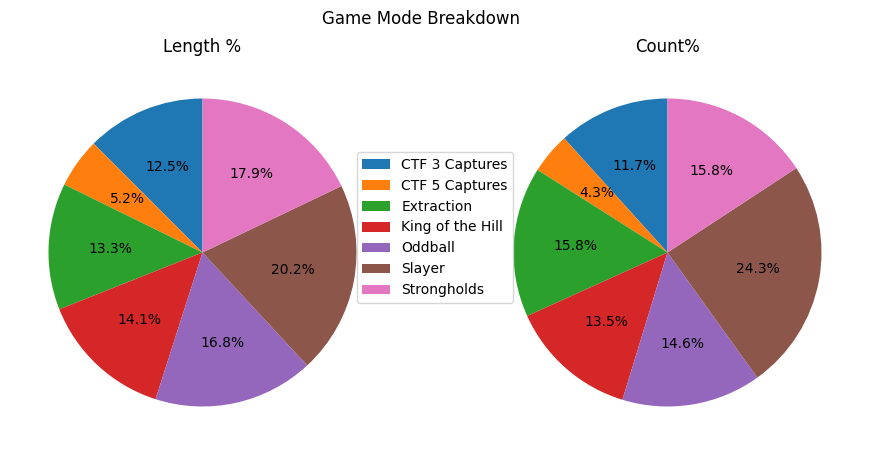

In [209]:
import matplotlib.pyplot as plt

labels = dfrc.index.get_level_values('Category').tolist()
sizes_length = dfrc['Length%'].tolist()
sizes_count = dfrc['Count%'].tolist()

fig, ax = plt.subplots(1, 2, figsize=(11, 5))  # Create a subplot with 1 row and 2 columns
ax[0].pie(sizes_length, labels=None, autopct='%1.1f%%', startangle=90)
ax[1].pie(sizes_count, labels=None, autopct='%1.1f%%', startangle=90)
fig.suptitle('Game Mode Breakdown')
ax[0].set(aspect="equal", title='Length %')
ax[1].set(aspect="equal", title='Count%')
fig.legend(labels, loc="center")

plt.show()

In [210]:
dfrc = dfr.groupby(['Category','Map']).agg({'Category': 'count', 'LengthMinutes': 'sum', 'Outcome': 'mean'})
dfrc.rename(columns={'Category': 'Count', 'LengthMinutes': 'LengthHours'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthHours']/60,2)
dfrc['Outcome'] = round(dfrc['Outcome'],2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['Length%'] = round(dfrc['LengthHours'] / dfrc['LengthHours'].sum() * 100,2)
dfrc = dfrc.sort_values(['Length%'], ascending=False)
dfrc

,,Count,LengthHours,Outcome,Count%,Length%
Category,Map,,,,,
Strongholds,Solitude,32,6.72,0.41,7.21,8.75
Oddball,Streets,28,5.64,0.54,6.31,7.34
King of the Hill,Recharge,27,5.29,0.59,6.08,6.89
Slayer,Aquarius,35,4.98,0.60,7.88,6.49
Extraction,Streets,33,4.74,0.61,7.43,6.17
Slayer,Solitude,32,4.72,0.59,7.21,6.15
CTF 5 Captures,Aquarius,19,4.01,0.37,4.28,5.22
Strongholds,Recharge,20,3.77,0.40,4.50,4.91
Oddball,Recharge,19,3.73,0.47,4.28,4.86


In [211]:
dfrcc = dfr.groupby(['Category','Map']).agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'ShotsLanded' : 'sum',
                                             'ShotsFired' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             'LengthMinutes': 'sum',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['Accuracy'] = (dfrcc['ShotsLanded'] / dfrcc['ShotsFired']) *100
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Kills/10Min'] = dfrcc['Kills'] / dfrcc['LengthMinutes'] * 10
dfrcc['Deaths/10Min'] = dfrcc['Deaths'] / dfrcc['LengthMinutes'] * 10
dfrcc['Assists/10Min'] = dfrcc['Assists'] / dfrcc['LengthMinutes'] * 10
dfrcc['KDA/10Min'] = (dfrcc['Kills/10Min'] + (dfrcc['Assists/10Min'] / 3)) / dfrcc['Deaths/10Min'] 
dfrcc = dfrcc.drop(['ShotsLanded', 'ShotsFired'], axis=1)
# dfrcc = round(dfrcc.sort_values(['Winrate', 'Accuracy'], ascending=False),2)
dfrcc = round(dfrcc.sort_values('Accuracy', ascending=False),2)
dfrcc

Count  Kills  Deaths  Assists  DamageDone  \
Category         Map                                                    
Extraction       Live Fire     19    230     216      125       82363   
                 Streets       33    453     351      253      147191   
Oddball          Streets       28    492     444      305      172665   
King of the Hill Live Fire     20    286     261      134       93315   
Strongholds      Solitude      32    614     527      354      207424   
CTF 3 Captures   Forbidden     16    235     178      110       83018   
Strongholds      Live Fire     18    277     234      116       94049   
King of the Hill Solitude      13    255     189      125       79048   
Oddball          Live Fire     18    280     282      198      107663   
Extraction       Recharge      18    230     193      143       80159   
CTF 5 Captures   Aquarius      19    371     290      183      125998   
Slayer           Aquarius      35    375     350      224      144316   
King of the Hill Recharge      27    491     431      329      171249   
CTF 3 Captures   Empyrean      18    263     249      149       92507   
Slayer           Solitude      32    347     353      211      133538   
Oddball          Recharge      19    307     260      184      111343   
CTF 3 Captures   Argyle        18    256     220      119       90105   
Strongholds      Recharge      20    292     293      191      110281   
Slayer           Live Fire     15    153     153       79       56576   
                 Streets       16    147     142      108       59038   
                 Recharge      10     92      93       73       41703   

                            DamageTaken  Winrate  LengthMinutes  Accuracy  \
Category         Map                                                        
Extraction       Live Fire        72351     0.42         162.17     55.24   
                 Streets         118482     0.61         284.25     54.27   
Oddball          Streets         149097     0.54         338.37     53.76   
King of the Hill Live Fire        84979     0.75         182.30     53.75   
Strongholds      Solitude        176130     0.41         403.27     52.72   
CTF 3 Captures   Forbidden        64485     0.62         171.10     52.34   
Strongholds      Live Fire        84481     0.56         195.18     52.01   
King of the Hill Solitude         65007     0.46         148.55     51.63   
Oddball          Live Fire        90643     0.61         213.22     51.57   
Extraction       Recharge         66596     0.61         165.43     51.43   
CTF 5 Captures   Aquarius         99608     0.37         240.87     51.32   
Slayer           Aquarius        127422     0.60         299.02     50.85   
King of the Hill Recharge        145545     0.59         317.15     50.84   
CTF 3 Captures   Empyrean         82939     0.39         200.88     50.75   
Slayer           Solitude        123115     0.59         283.30     50.33   
Oddball          Recharge         93994     0.47         223.63     49.25   
CTF 3 Captures   Argyle           76644     0.50         203.95     48.98   
Strongholds      Recharge         96556     0.40         226.12     48.71   
Slayer           Live Fire        54644     0.40         131.95     48.52   
                 Streets          51569     0.75         125.57     48.14   
                 Recharge         37402     0.60          90.97     47.45   

                              KD  DamageRatio  Dmg/Life  ExDmg/Life  \
Category         Map                                                  
Extraction       Live Fire  1.06         1.14    381.31       46.35   
                 Streets    1.29         1.24    419.35       81.79   
Oddball          Streets    1.11         1.16    388.89       53.08   
King of the Hill Live Fire  1.10         1.10    357.53       31.94   
Strongholds      Solitude   1.17         1.18    393.59       59.38   
CTF 3 Captures   Forbidden  1.32         1.29    466.39      104.12   
Strongho

In [212]:
dfrcc = dfr.groupby('Category').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Category,,,,,,,,,,,,
King of the Hill,60,1032,881,588,343612,295531,0.62,1.17,1.16,390.02,54.58,0.67
Slayer,108,1114,1091,695,435171,394152,0.59,1.02,1.10,398.87,37.60,0.64
Extraction,70,913,760,521,309713,257429,0.56,1.20,1.20,407.52,68.79,0.69
Oddball,65,1079,986,687,391671,333734,0.54,1.09,1.17,397.23,58.76,0.70
CTF 3 Captures,52,754,647,378,265630,224068,0.50,1.17,1.19,410.56,64.24,0.58
Strongholds,70,1183,1054,661,411754,357167,0.44,1.12,1.15,390.66,51.79,0.63
CTF 5 Captures,19,371,290,183,125998,99608,0.37,1.28,1.26,434.48,91.00,0.63


In [213]:
dfrcc = dfr.groupby('Map').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Assists/Life', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Map,,,,,,,,,,,,
Recharge,94,1412,1270,920,514735,440093,0.53,1.11,1.17,405.30,58.77,0.72
Streets,77,1092,937,666,378894,319148,0.61,1.17,1.19,404.37,63.76,0.71
Solitude,77,1216,1069,690,420010,364252,0.49,1.14,1.15,392.90,52.16,0.65
Aquarius,54,746,640,407,270314,227030,0.52,1.17,1.19,422.37,67.63,0.64
Forbidden,16,235,178,110,83018,64485,0.62,1.32,1.29,466.39,104.12,0.62
Empyrean,18,263,249,149,92507,82939,0.39,1.06,1.12,371.51,38.43,0.60
Live Fire,90,1226,1146,652,433966,387098,0.56,1.07,1.12,378.68,40.90,0.57
Argyle,18,256,220,119,90105,76644,0.50,1.16,1.18,409.57,61.19,0.54


In [214]:
print(f'Runtime: {time.perf_counter() - start}s')

Runtime: 9.139047833974473s
